In [277]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str

In [2]:
charting.set_mpl_style()

In [147]:
# Reusable SQL chunks
sql_chunks = {
    "is_experiment_participant": """
    event.bucket in ('default-visual', 'default-source') and
    year = 2019 and month = 7 and day < 10
    """
}

# Events by platform and registration status

Since 3 June, when we [fixed the problem](https://phabricator.wikimedia.org/T221197#5305239) that led to many invalid mobile events, the number of phone events has recovered *past* pre-bug levels to reach a higher level than before (because the A/B test resulted in some of these editors moving to the visual editor, where all rather than 1/16 of their sessions are sampled). 

**Verdict: all good!**

In [3]:
events_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    sum(cast(event.platform = "desktop" and event.user_id != 0 as int)) as registered_desktop,
    sum(cast(event.platform = "desktop" and event.user_id = 0 as int)) as anonymous_desktop,
    sum(cast(event.platform = "phone" and event.user_id != 0 as int)) as registered_phone,
    sum(cast(event.platform = "phone" and event.user_id = 0 as int)) as anonymous_phone
from event.editattemptstep
where
    year = 2019 and (
        (month = 6 and day > 17) or
        (month = 7)
    )
group by date_format(dt, "yyyy-MM-dd")
order by date
limit 100
""")

In [5]:
events = (
    events_r
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .query("~(date == '2019-07-09')")
    .rename(lambda col: col.replace("_", " "), axis=1)
)

events

,date,registered desktop,anonymous desktop,registered phone,anonymous phone
0,2019-06-18,103855,230523,35744,286838
1,2019-06-19,104869,211305,32402,275964
2,2019-06-20,105994,201908,36134,283812
3,2019-06-21,104346,194389,33829,282477
4,2019-06-22,97378,164189,39652,298071
5,2019-06-23,101349,172402,36825,330253
6,2019-06-24,108487,234554,33555,299146
7,2019-06-25,111791,222482,26893,227859
8,2019-06-26,107107,232324,55,1410
9,2019-06-27,101278,212925,11,480


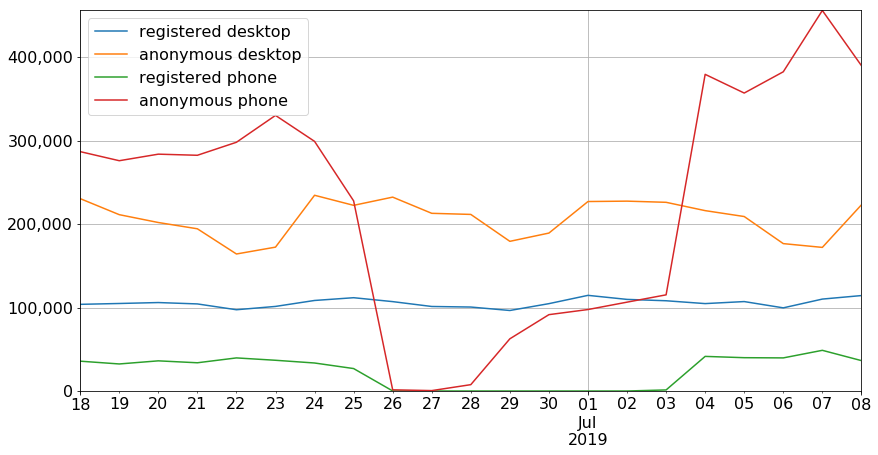

In [6]:
ax = events.set_index("date").plot()
plt.xlabel(None);
ax.yaxis.set_major_formatter(comma_fmt)

# Deployment on non-test wikis?

In [333]:
wrong_wiki_events_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    count(*) as wrong_wiki_events
from event.editattemptstep
where
    event.platform = "phone" and
    event.bucket in ('default-visual', 'default-source') and
    wiki not in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day > 23) or
        (month = 7) or (month = 8)
    )
group by date_format(dt, "yyyy-MM-dd")
""")

In [332]:
wrong_wiki_inits_r

,date,wrong_wiki_events


In [335]:
other_wiki_mobile_ve_events_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    count(*) as other_wiki_mobile_ve_events
from event.editattemptstep
where
    event.platform = "phone" and
    event.editor_interface = "visualeditor" and
    wiki not in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day > 15) or
        (month = 7) or (month = 8)
    )
group by date_format(dt, "yyyy-MM-dd")
""")

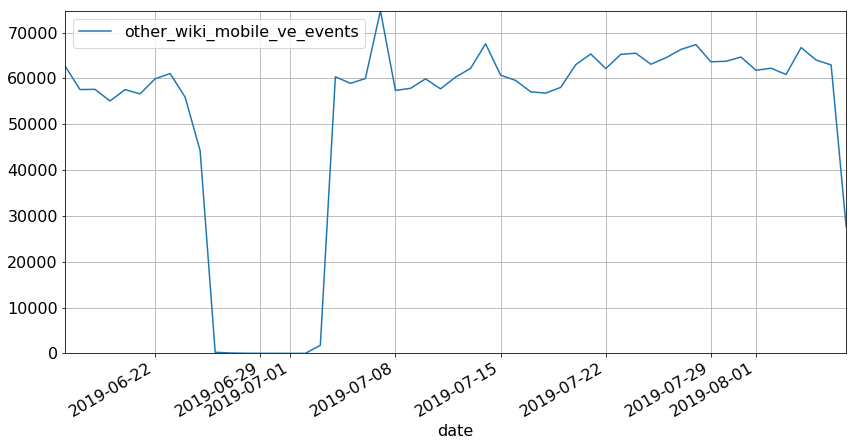

In [340]:
(
    other_wiki_mobile_ve_events_r
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .sort_values("date")
    .set_index("date")
).plot();

# Inits per bucket in test population

We are logging a reasonable amount of inits in each bucket among the expected experiment population (i.e. on the selected wikis and with fewer than 100 edits total). After data from registered edits returned, we started seeing a small number of users not bucketed, which makes sense since some users in the population will stay out of the buckets because they already had the sticky preference set.

With oversampling, we see a lot more events in the visual editing bucket because only mobile VE data is oversampled. Without oversampling, the number of inits in each buckets in pretty close. However, the visual editing bucket consistently has only 90% of the inits of the source editing bucket.

**Verdict: we should oversample mobile wikitext events at our test wikis and keep an eye on the imbalance in inits.**

## With oversampling

In [343]:
oversampled_inits_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    event.bucket as bucket,
    count(*) as events
from event.editattemptstep
where
    event.platform = "phone" and
    event.action = "init" and
    event.user_editcount < 100 and
    wiki in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day > 23) or
        (month = 7) or (month = 8)
    )
group by date_format(dt, "yyyy-MM-dd"), event.bucket
""")

In [347]:
oversampled_inits = (
    oversampled_inits_r
    .pivot(index="date", columns="bucket")
    .fillna(0)
    .xs("events", axis=1)
    .applymap(int)
    .rename({np.NaN: "none"}, axis=1)
    .query("~(date == '2019-08-07')")
)

oversampled_inits

bucket,none,default-source,default-visual
date,,,
2019-06-24,6422,0,0
2019-06-25,5107,0,0
2019-06-26,23,0,0
2019-06-27,10,0,0
2019-06-28,2,220,2374
2019-06-29,1,1785,20300
2019-06-30,1,2598,29779
2019-07-01,0,2788,32164
2019-07-02,0,2932,35256


Overall ratio of visual bucket inits to source bucket inits:

In [351]:
comparable_inits = inits.query("date > '2019-07-13'")

print(pct_str(
    comparable_inits["default-visual"].sum() / comparable_inits["default-source"].sum()
))

94.1%


## Without oversampling

In [345]:
inits_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    event.bucket as bucket,
    count(*) as init
from event.editattemptstep
where
    event.platform = "phone" and
    event.action = "init" and
    event.user_editcount < 100 and
    not event.is_oversample and
    wiki in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day > 23) or
        (month = 7)
    )
group by date_format(dt, "yyyy-MM-dd"), event.bucket
""")

In [349]:
inits = (
    inits_r
    .pivot(index="date", columns="bucket")
    .fillna(0)
    .xs("init", axis=1)
    .applymap(int)
    .rename({np.NaN: "none"}, axis=1)
    .query("~(date == '2019-08-07')")
)

inits

bucket,none,default-source,default-visual
date,,,
2019-06-24,5252,0,0
2019-06-25,4111,0,0
2019-06-26,21,0,0
2019-06-27,6,0,0
2019-06-28,2,167,152
2019-06-29,0,1431,1309
2019-06-30,1,2134,1858
2019-07-01,0,2303,2132
2019-07-02,0,2489,2200


# Inits per bucket among experienced editors at test wikis

Editors at test wikis with 100 edits or more should not be bucketed. Since the fix on 3 June, this seems to be happening (if the numbers seem low, consider that it's a small number of wikis and that these users are probably using wikitext, which is 1/16 sampled).

The few inits from our experimental buckets make sense, since rarely editors might actually move into this edit count range after being bucketed.

**Verdict: all good!**

In [ ]:
buckets_experienced_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    event.bucket as bucket,
    count(*) as events
from event.editattemptstep
where
    event.platform = "phone" and
    event.action = "init" and
    event.user_editcount >= 100 and
    wiki in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day > 23) or
        (month = 7)
    )
group by date_format(dt, "yyyy-MM-dd"), event.bucket
""")

In [20]:
index_without_gaps = pd.date_range(
    buckets_experienced_r["date"].iloc[0], 
    buckets_experienced_r["date"].iloc[-1],
    name="date"
)

buckets_experienced= (
    buckets_experienced_r
    .assign(
        date=lambda df: pd.to_datetime(df["date"]),
        bucket=lambda df: df["bucket"].fillna("none")
    )
    .pivot(index="date", columns="bucket")
    .xs("events", axis=1)
    .fillna(0)
    .applymap(int)
    .rename(columns={"none": "no bucket"})
    .rename_axis(None, axis=1)
    .reindex(index_without_gaps, fill_value=0)
    .reset_index()
)

buckets_experienced

,date,default-source,default-visual,no bucket
0,2019-06-26,0,0,1
1,2019-06-27,0,0,0
2,2019-06-28,0,0,0
3,2019-06-29,0,0,0
4,2019-06-30,0,0,0
5,2019-07-01,0,0,0
6,2019-07-02,0,0,0
7,2019-07-03,0,0,5
8,2019-07-04,1,0,153
9,2019-07-05,0,0,135


# Readies per bucket

In our test population, without oversampling, the `default-visual` bucket is seeing far fewer readies—only about 60% as many.

In [83]:
readies_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    event.bucket as bucket,
    count(*) as readies
from event.editattemptstep
where
    event.action = "ready" and
    not event.is_oversample and
    event.bucket in ('default-visual', 'default-source') and
    year = 2019 and (
        (month = 6 and day > 20) or
        (month = 7 and day < 9)
    )
group by date_format(dt, "yyyy-MM-dd"), event.bucket
""")

In [84]:
readies = (
    readies_r
    .pivot(index="date", columns="bucket")
    .fillna(0)
    .xs("readies", axis=1)
    .applymap(int)
)

readies

bucket,default-source,default-visual
date,,
2019-06-28,165,117
2019-06-29,1425,894
2019-06-30,2128,1192
2019-07-01,2292,1395
2019-07-02,2477,1387
2019-07-03,2512,1429
2019-07-04,2565,1464
2019-07-05,2243,1402
2019-07-06,2308,1419


In [85]:
print(
    "Ratio of visual bucket readies to source bucket readies:",
    pct_str(
        readies["default-visual"].sum() / readies["default-source"].sum()
    )
)

Ratio of visual bucket readies to source bucket readies: 59.2%


# Ready rate

## ...in test population

In [128]:
ready_rate = (readies / inits.drop("none", axis=1).query("date >= '2019-06-28'"))
ready_rate.style.format(pct_str)

bucket,default-source,default-visual
date,,
2019-06-28,98.8%,77.0%
2019-06-29,99.6%,68.3%
2019-06-30,99.7%,64.2%
2019-07-01,99.5%,65.4%
2019-07-02,99.5%,63.0%
2019-07-03,99.4%,63.3%
2019-07-04,99.5%,65.6%
2019-07-05,99.4%,66.6%
2019-07-06,99.7%,65.9%


In [131]:
ready_rate.applymap(pct_str).reset_index().pipe(df_to_remarkup)

| date | default-source | default-visual
| ----- | ----- | ----- 
| 2019-06-28 | 98.8% | 77.0%
| 2019-06-29 | 99.6% | 68.3%
| 2019-06-30 | 99.7% | 64.2%
| 2019-07-01 | 99.5% | 65.4%
| 2019-07-02 | 99.5% | 63.0%
| 2019-07-03 | 99.4% | 63.3%
| 2019-07-04 | 99.5% | 65.6%
| 2019-07-05 | 99.4% | 66.6%
| 2019-07-06 | 99.7% | 65.9%
| 2019-07-07 | 99.5% | 66.5%
| 2019-07-08 | 99.5% | 64.4%



## ...globally

In [167]:
global_ready_rate_r = hive.run("""
with attempts as (
    select
        date_format(min(dt), "yyyy-MM-dd") as date,
        event.editor_interface as editor,
        sum(cast(event.action = "ready" as int)) >= 1 as ready
    from event_sanitized.editattemptstep
    where
        event.action in ("init", "ready") and
        event.platform = "phone" and
        year > 0
    group by event.editor_interface, event.editing_session_id
)
select
    date,
    editor,
    sum(cast(ready as int)) / count(*) as ready_rate
from attempts
group by date, editor
""")

In the earliest data in this stream, the visual editor ready rate is around 99%, but it has now dropped to around 65%.

In [168]:
global_ready_rate = (
    global_ready_rate_r
    .assign(date=lambda df: pd.to_datetime(df["date"]).dt.to_period(freq="D"))
    .pivot(index="date", columns="editor")
    .xs("ready_rate", axis=1)
    .reindex(["wikitext", "visualeditor"], axis=1)
)

global_ready_rate.head().style.format(pct_str)

editor,wikitext,visualeditor
date,,
2018-11-27,100.0%,100.0%
2018-11-28,100.0%,99.9%
2018-11-29,100.0%,99.8%
2018-11-30,99.9%,99.6%
2018-12-01,99.9%,99.8%


The first drop happed from 1 May to 3 May 2019; this is essentially the deployment schedule of [MediaWiki 1.34/wmf.3](https://www.mediawiki.org/wiki/MediaWiki_1.34/wmf.3), which included a patch [fixing incorrectly low `ready` timings](https://phabricator.wikimedia.org/T217825).

In [188]:
global_ready_rate["2019-04-27":"2019-05-07"].style.format(pct_str)

editor,wikitext,visualeditor
date,,
2019-04-27,99.8%,98.4%
2019-04-28,99.8%,98.6%
2019-04-29,99.8%,98.4%
2019-04-30,99.9%,98.7%
2019-05-01,99.8%,98.7%
2019-05-02,99.8%,95.3%
2019-05-03,99.8%,84.4%
2019-05-04,99.8%,84.0%
2019-05-05,99.8%,83.7%


The second drop happened during the process of deploying the A/B test (so it almost certainly had to do with an influx of less-experienced users to VE rather than a regression in the software).

In [213]:
global_ready_rate["2019-06-21":"2019-07-03"].style.format(pct_str)

editor,wikitext,visualeditor
date,,
2019-06-21,99.8%,83.4%
2019-06-22,99.9%,84.1%
2019-06-23,99.9%,82.9%
2019-06-24,99.8%,83.4%
2019-06-25,99.9%,83.5%
2019-06-26,100.0%,80.8%
2019-06-27,100.0%,80.6%
2019-06-28,100.0%,71.6%
2019-06-29,99.9%,67.7%


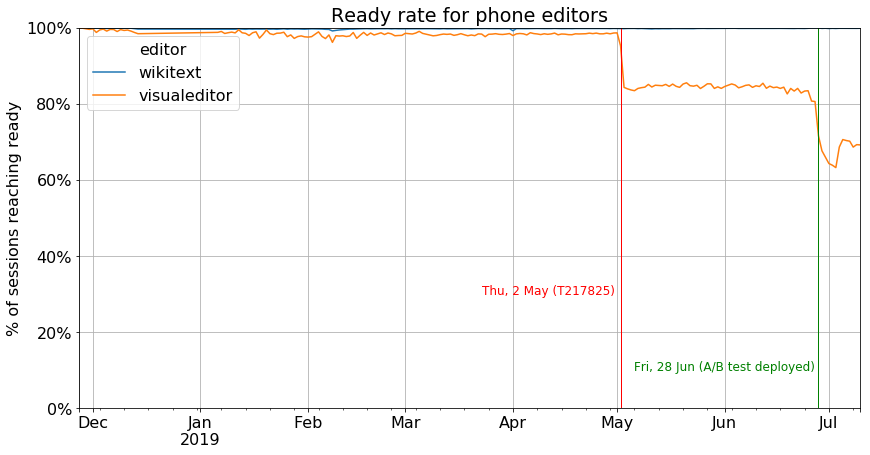

In [240]:
ax = global_ready_rate.plot(ylim=0)
ax.yaxis.set_major_formatter(pct_fmt)
plt.axvline("2019-05-02", color="red", linewidth=1)
plt.text("2019-03-23", 0.3, "Thu, 2 May (T217825)", size=12, color="red")
plt.axvline("2019-06-28", color="green", linewidth=1)
plt.text("2019-05-06", 0.1, "Fri, 28 Jun (A/B test deployed)", size=12, color="green")
plt.ylabel("% of sessions reaching ready")
plt.xlabel(None)
plt.title("Ready rate for phone editors");

# Distinct sessions reporting readies

The imbalance in ready events isn't caused by wikitext editor sessions mistakenly logging multiple events, since the imbalance is almost exactly the same when we count the number of distinct sessions which logged readies in each bucket.

Number of distinct sessions:

In [86]:
ready_sessions_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    event.bucket as bucket,
    count(distinct event.editing_session_id) as distinct_sessions
from event.editattemptstep
where
    event.action = "ready" and
    not event.is_oversample and
    event.bucket in ('default-visual', 'default-source') and
    year = 2019 and (
        (month = 6 and day > 20) or
        (month = 7 and day < 9)
    )
group by date_format(dt, "yyyy-MM-dd"), event.bucket
""")

In [87]:
ready_sessions = (
    ready_sessions_r
    .pivot(index="date", columns="bucket")
    .fillna(0)
    .xs("distinct_sessions", axis=1)
    .applymap(int)
)

ready_sessions

bucket,default-source,default-visual
date,,
2019-06-28,165,117
2019-06-29,1424,894
2019-06-30,2128,1191
2019-07-01,2292,1395
2019-07-02,2477,1387
2019-07-03,2511,1429
2019-07-04,2565,1464
2019-07-05,2240,1402
2019-07-06,2308,1419


There is almost exactly one ready per ready-logging session, so almost no duplication.

In [89]:
readies / ready_sessions

bucket,default-source,default-visual
date,,
2019-06-28,1.000000,1.00000
2019-06-29,1.000702,1.00000
2019-06-30,1.000000,1.00084
2019-07-01,1.000000,1.00000
2019-07-02,1.000000,1.00000
2019-07-03,1.000398,1.00000
2019-07-04,1.000000,1.00000
2019-07-05,1.001339,1.00000
2019-07-06,1.000000,1.00000


# Ready timings by editor in test population

Among people in our test (which is important because it mostly removes the possibility that users are choosing editors *because* of their device or connection), the mobile visual editor takes *much* longer to load than the mobile wikitext editor.

In [38]:
ready_times_r = hive.run("""
select
    event.editor_interface as editor,
    percentile_approx(event.ready_timing, 0.1) as 10th_percentile,
    percentile_approx(event.ready_timing, 0.5) as median,
    percentile_approx(event.ready_timing, 0.9) as 90th_percentile
from event.editattemptstep
where
    event.bufcket in ("default-source", "default-visual") and
    event.action = "ready" and
    year = 2019 and (
        (month = 6 and day > 28) or
        (month = 7 and day < 9)
    )
group by event.editor_interface
""")

In [118]:
ready_times = (
    ready_times_r
    .set_index("editor")
    .transpose()
    .applymap(int)
)

ready_times

editor,visualeditor,wikitext
10th_percentile,1136,218
median,2868,560
90th_percentile,7917,2020


In [132]:
ready_times.reset_index().pipe(df_to_remarkup)

| index | visualeditor | wikitext
| ----- | ----- | ----- 
| 10th_percentile | 1136 | 218
| median | 2868 | 560
| 90th_percentile | 7917 | 2020



# Ready timings by editor globally

But this isn't limited to our test population—the story is pretty much identical when you look at all users.

In [50]:
global_ready_times_r = hive.run("""
select
    event.editor_interface as editor,
    percentile_approx(event.ready_timing, 0.1) as 10th_percentile,
    percentile_approx(event.ready_timing, 0.5) as median,
    percentile_approx(event.ready_timing, 0.9) as 90th_percentile
from event.editattemptstep
where
    event.platform = "phone" and
    event.action = "ready" and
    year = 2019 and (
        (month = 6 and day > 28) or
        (month = 7 and day < 9)
    )
group by event.editor_interface
""")

In [57]:
global_ready_times = (
    global_ready_times_r
    .set_index("editor")
    .transpose()
    .applymap(int)
)

global_ready_times

editor,visualeditor,wikitext
10th_percentile,1111,184
median,2840,513
90th_percentile,8184,1912


In [217]:
hist_ready_times_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd"),
    percentile_approx(event.ready_timing, 0.1) as 10th_percentile,
    percentile_approx(event.ready_timing, 0.5) as median,
    percentile_approx(event.ready_timing, 0.9) as 90th_percentile
from event_sanitized.editattemptstep
where
    event.platform = "phone" and
    event.editor_interface = "visualeditor" and
    event.action = "ready" and
    year > 0
group by date_format(dt, "yyyy-MM-dd")
""")

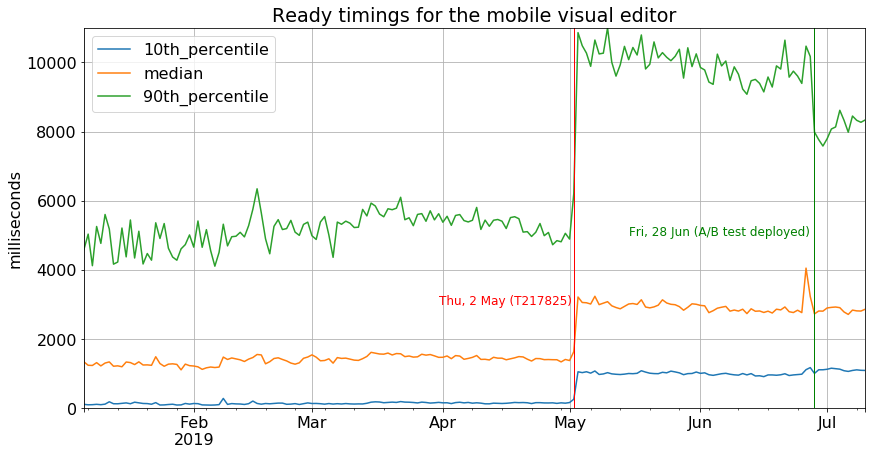

In [296]:
hist_ready_times = (
    hist_ready_times_r
    .rename({"_c0": "date"}, axis=1)
    .assign(date=lambda df: pd.to_datetime(df["date"]).dt.to_period(freq="D"))
    .sort_values("date")
    .set_index("date")
    .loc["2019-01-06":]
)

hist_ready_times.plot(ylim=0)
plt.axvline("2019-05-02", color="red", linewidth=1)
plt.text("2019-03-31", 3000, "Thu, 2 May (T217825)", size=12, color="red")
plt.axvline("2019-06-28", color="green", linewidth=1)
plt.text("2019-05-15", 5000, "Fri, 28 Jun (A/B test deployed)", size=12, color="green")
plt.ylabel("milliseconds")
plt.xlabel(None)
plt.title("Ready timings for the mobile visual editor");

# Saves per bucket

In [90]:
saves_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    event.bucket as bucket,
    count(*) as saves
from event.editattemptstep
where
    event.action = "saveSuccess" and
    not event.is_oversample and
    event.bucket in ('default-visual', 'default-source') and
    year = 2019 and (
        (month = 6 and day > 20) or
        (month = 7 and day < 9)
    )
group by date_format(dt, "yyyy-MM-dd"), event.bucket

""")

In [92]:
saves = (
    saves_r
    .pivot(index="date", columns="bucket")
    .fillna(0)
    .xs("saves", axis=1)
    .applymap(int)
)

saves

bucket,default-source,default-visual
date,,
2019-06-28,4,3
2019-06-29,56,41
2019-06-30,58,39
2019-07-01,50,43
2019-07-02,72,44
2019-07-03,69,55
2019-07-04,78,60
2019-07-05,66,59
2019-07-06,75,48


In [93]:
print(
    "Ratio of visual bucket saves to source bucket saves:",
    pct_str(
        saves["default-visual"].sum() / saves["default-source"].sum()
    )
)

Ratio of visual bucket saves to source bucket saves: 75.6%


# Edit completion rate

Edit completion based on actually reconstructing sessions:

In [360]:
completion_r = hive.run("""
with attempts as (
    select
        date_format(min(dt), "yyyy-MM-dd") as date,
        event.bucket as bucket,
        sum(cast(event.action = "saveSuccess" as int)) >= 1 as completed
    from event.editattemptstep
    where
        event.action in ("ready", "saveSuccess") and
        event.bucket in ("default-source", "default-visual") and
        year = 2019 and ((month = 6 and day >= 15) or month = 7 or month = 8 )
    group by event.bucket, event.editing_session_id
)
select
    date,
    bucket,
    sum(cast(completed as int)) / count(*) as edit_completion_rate
from attempts
group by date, bucket
""")

In [363]:
completion_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 3 columns):
date                    82 non-null object
bucket                  82 non-null object
edit_completion_rate    82 non-null float64
dtypes: float64(1), object(2)
memory usage: 2.0+ KB


In [361]:
(
    completion_r
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .sort_values("date")
    .pivot(index="date", columns="bucket")
    .style.format(pct_str)
)

Same method, but removing oversampled sessions (a big chunk of the VE sessions). It's very different, but that doesn't make sense, since the remaining VE sessions should just be a random 1/16 sample.

In [358]:
non_oversampled_completion_r = hive.run("""
with attempts as (
    select
        date_format(min(dt), "yyyy-MM-dd") as date,
        event.bucket as bucket,
        sum(cast(event.action = "saveSuccess" as int)) >= 1 as completed
    from event.editattemptstep
    where
        not event.is_oversample and
        event.action in ("ready", "saveSuccess") and
        event.bucket in ("default-source", "default-visual") and
        year = 2019 and ((month = 6 and day >= 15) or month = 7 or month = 8 )
    group by event.bucket, event.editing_session_id
)
select
    date,
    bucket,
    sum(cast(completed as int)) / count(*) as edit_completion_rate
from attempts
group by date, bucket
""")

In [359]:
(
    non_oversampled_completion_r
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .sort_values("date")
    .pivot(index="date", columns="bucket")
    .style.format(pct_str)
)

# Early edit completion rate

Before we started oversampling

# Correspondence between buckets and editors

In [233]:
default_editor_inits_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    sum(cast(
        array(event.bucket, event.editor_interface) in (
            array("default-source", "wikitext"),
            array("default-visual", "visualeditor")
        )
    as int)) / count(*) as default_editor_inits
from event.editattemptstep
where
    event.platform = "phone" and
    event.action = "init" and
    event.bucket in ("default-source", "default-visual") and
    wiki in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day >= 28) or
        (month = 7)
    )
group by date_format(dt, "yyyy-MM-dd")
""")

In [236]:
default_editor_inits = (
    default_editor_inits_r
    .assign(
        default_editor_inits=lambda df: df["default_editor_inits"].map(pct_str)
    ).sort_values("date")
)

default_editor_inits

,date,default_editor_inits
0,2019-06-28,97.6%
3,2019-06-29,98.1%
4,2019-06-30,98.4%
1,2019-07-01,98.4%
5,2019-07-02,98.6%
2,2019-07-03,98.5%
6,2019-07-04,97.9%


# Buckets per user

In [252]:
multiple_buckets_r = hive.run("""
select
    user_type,
    sum(cast(distinct_buckets > 1 as int)) / count(*) as multiple_buckets
from (
    select
        if(event.user_id = 0, "anonymous", "registered") as user_type,
        count(distinct event.bucket) as distinct_buckets
    from event.editattemptstep
    where
        event.platform = "phone" and
        wiki in (
            'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
            'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
            'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
            'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
        ) and
        year = 2019 and (
            (month = 6 and day > 23) or
            (month = 7)
        )
    group by
        wiki,
        if(event.user_id = 0, event.anonymous_user_token, event.user_id),
        if(event.user_id = 0, "anonymous", "registered")
) buckets_per_user
group by user_type
""")

In [253]:
multiple_buckets = multiple_buckets_r.assign(
    multiple_buckets=lambda df: df["multiple_buckets"].map(pct_str)
)

multiple_buckets

,user_type,multiple_buckets
0,anonymous,0.0%
1,registered,0.0%


# Anonymous editors with tokens

In [214]:
anons_with_tokens_r = hive.run("""
select
    date_format(dt, "yyyy-MM-dd") as date,
    sum(cast(event.anonymous_user_token is not null as int)) / count(*) as anonymous_users_with_tokens
from event.editattemptstep
where
    event.platform = "phone" and
    event.user_id = 0 and
    wiki in (
        'azwiki', 'bgwiki', 'zh_yuewiki', 'cawiki', 'hrwiki',
        'dawiki', 'etwiki', 'fiwiki', 'elwiki', 'huwiki',
        'mswiki', 'mlwiki', 'nowiki', 'ptwiki', 'rowiki',
        'srwiki', 'svwiki', 'tawiki', 'thwiki', 'urwiki'
    ) and
    year = 2019 and (
        (month = 6 and day > 23) or
        (month = 7)
    )
group by date_format(dt, "yyyy-MM-dd")
""")

In [216]:
anons_with_tokens_r.sort_values("date").assign(
    anonymous_users_with_tokens=lambda df: df["anonymous_users_with_tokens"].map(pct_str)
)

,date,anonymous_users_with_tokens
0,2019-06-24,0.0%
4,2019-06-25,0.0%
7,2019-06-26,0.0%
1,2019-06-27,0.0%
5,2019-06-28,99.9%
8,2019-06-29,100.0%
2,2019-06-30,100.0%
9,2019-07-01,100.0%
3,2019-07-02,100.0%
6,2019-07-03,100.0%


# New revision IDs in saveSuccess events

There are a lot of edits with a revision ID of 0.

In [325]:
hive.run("""
select 
    event.platform as platform,
    event.editor_interface as editor,
    count(*) as null_revid_events
from event.editattemptstep
where
    event.revision_id = 0 and
    year = 2019 and month = 8 and day = 6
group by event.platform, event.editor_interface
""")

,platform,editor,null_revid_events
0,desktop,visualeditor,60485
1,desktop,wikitext,134565
2,desktop,wikitext-2017,304
3,phone,visualeditor,24403
4,phone,wikitext,46817


The ones which also have a page ID of 0 seem to be trying to create pages which don't exist, but there are plenty of others which do have a page ID.

In [370]:
hive.run("""
select
    wiki,
    event.action,
    event.page_title,
    event.page_id,
    event.page_ns
from event.editattemptstep
where
    event.revision_id = 0 and
    year = 2019 and month = 8 and day = 8
limit 50
""")

,wiki,action,page_title,page_id,page_ns
0,eswiki,loaded,After:_En_Mil_Pedazos,0,0
1,itwiki,init,Lista_di_compagnie_aeree_di_bandiera,1988047,0
2,dewiktionary,init,Mielert,0,0
3,enwiki,ready,Mask_(Fanatic_Crisis_album),55479138,0
4,eswiki,loaded,Edgewall_Software,0,0
5,thwiki,init,ทะไลลามะ_องค์ที่แปด,0,0
6,enwiki,loaded,User:Kawnhr/sandbox,0,2
7,ptwiki,ready,História_da_Nova_Zelândia,15487,0
8,eswiki,init,Microscopio,3273,0
9,kowiki,ready,팔자명리,0,0


In [378]:
missing_rev_id_events_r = hive.run("""
select
    event.platform,
    event.editor_interface,
    event.action,
    count(*) as events
from event.editattemptstep
where
    event.revision_id = 0 and
    event.page_id != 0 and
    year = 2019 and month = 8 and day = 7
group by
    event.platform,
    event.editor_interface,
    event.action
""")

These events with "missing" revision IDs are concentrated among the earlier events, and essentially none are save success events, which means they aren't very severe for our problems here.

In [381]:
missing_rev_id_events = (
    missing_rev_id_events_r
    .pivot_table(index=["platform", "editor_interface"], columns="action")
    .xs("events", axis=1)
    .fillna(0)
    .applymap(int)
)

missing_rev_id_events

action                     abort  init  loaded  ready  saveAttempt  \
platform editor_interface                                            
desktop  visualeditor        518   778     711    711          207   
         wikitext           8862     0   26543  26625            0   
phone    visualeditor          4  1678    1377   1380          235   
         wikitext            941  5342    5311   5315          183   

action                     saveFailure  saveIntent  saveSuccess  
platform editor_interface                                        
desktop  visualeditor               56         199            1  
         wikitext                    0           0            0  
phone    visualeditor               81         196            3  
         wikitext                   35         253            2

In [384]:
missing_rev_id_prop_r = hive.run("""
select
    event.platform,
    event.editor_interface,
    event.action,
    sum(cast(event.revision_id = 0 and event.page_id != 0 as int)) / count(*) as missing_rev_id
from event.editattemptstep
where
    year = 2019 and month = 8 and day = 7
group by
    event.platform,
    event.editor_interface,
    event.action
""")

In [388]:
missing_rev_id_prop = (
    missing_rev_id_prop_r
    .pivot_table(index=["platform", "editor_interface"], columns="action")
    .xs("missing_rev_id", axis=1)
    .fillna(0)
    .applymap(pct_str)
)

missing_rev_id_prop

action                     abort  init loaded  ready saveAttempt saveFailure  \
platform editor_interface                                                      
desktop  visualeditor       3.0%  3.8%   3.7%   3.7%       11.6%       12.9%   
         wikitext          48.0%  0.0%  68.7%  68.5%        0.0%        0.0%   
         wikitext-2017      0.0%  0.0%   0.0%   0.0%        0.0%        0.0%   
phone    visualeditor       0.0%  3.1%   3.6%   3.6%        3.7%        6.1%   
         wikitext           1.2%  4.8%   4.8%   4.8%        3.6%        4.9%   

action                    saveIntent saveSuccess  
platform editor_interface                         
desktop  visualeditor          11.9%        0.1%  
         wikitext               0.0%        0.0%  
         wikitext-2017          0.0%        0.0%  
phone    visualeditor           3.1%        0.1%  
         wikitext               3.4%        0.0%

With that out of the way, do the non-zero revision IDs that are being logged in `saveSuccess` events represent the newly saved edits, as they should?

In [320]:
rev_ids_r = hive.run("""
with saves as (
    select
        dt,
        event.editing_session_id as attempt_id,
        event.revision_id as revision_id,
        event.platform as platform,
        event.editor_interface as editor
    from event.editattemptstep
    where
        event.action = "saveSuccess" and
        year = 2019 and (
            (month = 6 and day > 23) or
            (month = 7)
        ) and
        -- Remove Flow and other non-standard edits
        event.integration = "page"
),
pre_saves as (
    select
        event.editing_session_id as attempt_id,
        max(event.revision_id) as max_revision_id
    from event.editattemptstep
    where
        event.action != "saveSuccess" and
        year = 2019 and (
            (month = 6 and day > 23) or
            (month = 7)
        ) and
        -- Remove Flow and other non-standard edits
        event.integration = "page"
    group by event.editing_session_id
)
select
    date_format(dt, "yyyy-MM-dd") as date,
    platform,
    editor,
    sum(cast(saves.revision_id > pre_saves.max_revision_id as int)) / count(*) as save_has_greater_revision_id
from saves 
left join pre_saves
on saves.attempt_id = pre_saves.attempt_id
group by
    date_format(dt, "yyyy-MM-dd"),
    platform,
    editor
""")

In [321]:
rev_ids = (
    rev_ids_r
    .assign(
        editor=lambda df: df["platform"] + " " + df["editor"]
    )
    .drop("platform", axis=1)
    .pivot(index="date", columns="editor")
    .fillna(0)
    .xs("save_has_greater_revision_id", axis=1)
    .applymap(pct_str)
    .reset_index()
)

rev_ids

editor,date,desktop visualeditor,desktop wikitext,desktop wikitext-2017,phone visualeditor,phone wikitext
0,2019-06-24,0.0%,96.4%,0.0%,0.0%,0.0%
1,2019-06-25,0.0%,95.6%,0.0%,0.0%,0.0%
2,2019-06-26,0.0%,95.9%,0.0%,0.0%,0.0%
3,2019-06-27,0.0%,95.9%,0.0%,0.0%,0.0%
4,2019-06-28,0.0%,96.1%,0.0%,0.0%,0.0%
5,2019-06-29,0.0%,96.7%,0.0%,0.0%,0.0%
6,2019-06-30,0.0%,96.8%,0.0%,0.0%,0.0%
7,2019-07-01,0.0%,96.2%,0.0%,0.0%,0.0%
8,2019-07-02,0.0%,96.1%,0.0%,0.0%,0.0%
9,2019-07-03,0.0%,96.4%,0.0%,0.0%,0.0%


Let's get a sample of those remaining ~3% that don't properly log the new ID.

In [392]:
old_rev_ids_r = hive.run("""
with saves as (
    select
        dt,
        event.editing_session_id as attempt_id,
        event.revision_id as saved_revision_id,
        event.platform as platform,
        event.editor_interface as editor,
        event.user_id as user_id,
        wiki,
        event.page_title as page_title,
    from event.editattemptstep
    where
        event.action = "saveSuccess" and
        year = 2019 and month = 8 and day = 8 and
        -- Remove Flow and other non-standard edits
        event.integration = "page"
),
pre_saves as (
    select
        event.editing_session_id as attempt_id,
        max(event.revision_id) as base_revision_id
    from event.editattemptstep
    where
        event.action != "saveSuccess" and
        year = 2019 and month = 8 and day = 8 and
        -- Remove Flow and other non-standard edits
        event.integration = "page"
    group by event.editing_session_id
)
select
    wiki,
    user_id,
    page_title,
    base_revision_id,
    saved_revision_id,
    dt,
    

from saves 
left join pre_saves
on saves.attempt_id = pre_saves.attempt_id
where saved_revision_id <= base_revision_id
limit 1000
""")

In [395]:
old_rev_ids_r.sample(10)

,dt,attempt_id,saved_revision_id,platform,editor,wiki,page_ns,page_id,page_title,useragent,attempt_id,base_revision_id
533,2019-08-08T19:58:31Z,e9e3ea503b2e38615a36f68b323a49db,909966419,desktop,wikitext,enwiki,0,60646188,2004 Alor earthquake,"{""browser_family"":""Chrome"",""browser_major"":""49...",e9e3ea503b2e38615a36f68b323a49db,909966419
3,2019-08-08T00:10:54Z,0163f490440fffd24b9187f15ace687c,892063186,desktop,wikitext,enwiki,100,57321777,Portal:Alpine Rhine Valley,"{""browser_family"":""Chrome"",""browser_major"":""75...",0163f490440fffd24b9187f15ace687c,892063186
269,2019-08-08T19:27:36Z,70da7d8a5ca469968f23,909961371,phone,visualeditor,enwiki,0,1325666,Thovalai,"{""browser_family"":""Chrome Mobile"",""browser_maj...",70da7d8a5ca469968f23,909961371
507,2019-08-08T16:49:27Z,dc5806a0bef703f39241c939abb234e3,3869485,desktop,wikitext,mkwiki,0,11257,Луковица (Македонска Каменица),"{""browser_family"":""Mobile Safari"",""browser_maj...",dc5806a0bef703f39241c939abb234e3,3869485
453,2019-08-08T00:30:50Z,c11e7e5025fa419429d18465ff91892a,118080628,desktop,wikitext,eswiki,0,7085655,Quintino (DJ),"{""browser_family"":""Chrome"",""browser_major"":""75...",c11e7e5025fa419429d18465ff91892a,118080628
202,2019-08-08T01:51:29Z,578ed5d07a883a22346b379eeafb321e,909856158,desktop,wikitext,enwiki,0,1072260,Ha*Ash,"{""browser_family"":""Opera"",""browser_major"":""62""...",578ed5d07a883a22346b379eeafb321e,909856158
311,2019-08-08T11:43:27Z,7f301040aae12b7a9d0a8d313c507578,909906264,desktop,wikitext,enwiki,2,47513516,User:M00036/sandbox,"{""browser_family"":""Chrome"",""browser_major"":""75...",7f301040aae12b7a9d0a8d313c507578,909906264
506,2019-08-08T16:49:27Z,dc5806a0bef703f39241c939abb234e3,3869485,desktop,wikitext,mkwiki,0,11257,Луковица (Македонска Каменица),"{""browser_family"":""Mobile Safari"",""browser_maj...",dc5806a0bef703f39241c939abb234e3,3869485
530,2019-08-08T01:34:36Z,e8ac551443886886ff01,8439683,phone,wikitext,thwiki,0,42096,ศาสนาฮินดู,"{""browser_family"":""Mobile Safari"",""browser_maj...",e8ac551443886886ff01,8439683
595,2019-08-08T13:48:15Z,fde3bb8214f5becd988a,15425021,phone,visualeditor,idwiki,0,2661028,Cinta_Suci,"{""browser_family"":""Mobile Safari"",""browser_maj...",fde3bb8214f5becd988a,15425021


# Editor switching

In [308]:
switches_r = hive.run("""
select
    date,
    editor,
    sum(cast(switches >= 1 as int)) / count(*) as sessions_with_switches
from (
    select
        date_format(dt, "yyyy-MM-dd") as date,
        event.editing_session_id as editingsessionid,
        concat(event.platform, " ", event.editor_interface) as editor
    from event.editattemptstep
    where
        event.action = "ready" and
        year = 2019 and (
            (month = 6 and day > 23) or
            (month = 7)
        )
) readies
left join (
    select
        event.editingsessionid as editingsessionid,
        count(*) as switches
    from event.visualeditorfeatureuse
    where
        event.feature = "editor-switch" and
        year = 2019 and (
            (month = 6 and day > 23) or
            (month = 7)
        )
    group by event.editingsessionid
) switches
on readies.editingsessionid = switches.editingsessionid
group by date, editor
""")

In [313]:
switches = (
    switches_r
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .pivot(index="date", columns="editor")
    .fillna(0)
    .xs("sessions_with_switches", axis=1)
)

switches.style.format(pct_str)

editor,desktop visualeditor,desktop wikitext,desktop wikitext-2017,phone visualeditor,phone wikitext
date,,,,,
2019-06-24 00:00:00,0.0%,0.0%,0.0%,0.0%,0.0%
2019-06-25 00:00:00,0.0%,0.0%,0.0%,0.0%,0.0%
2019-06-26 00:00:00,0.0%,0.0%,0.0%,0.0%,0.0%
2019-06-27 00:00:00,0.0%,0.0%,0.0%,0.0%,0.0%
2019-06-28 00:00:00,0.0%,0.0%,0.0%,1.5%,0.0%
2019-06-29 00:00:00,0.0%,0.0%,0.0%,1.1%,0.9%
2019-06-30 00:00:00,0.0%,0.0%,0.0%,0.9%,0.6%
2019-07-01 00:00:00,0.0%,0.0%,0.0%,1.1%,0.8%
2019-07-02 00:00:00,0.0%,0.0%,0.0%,1.2%,0.8%


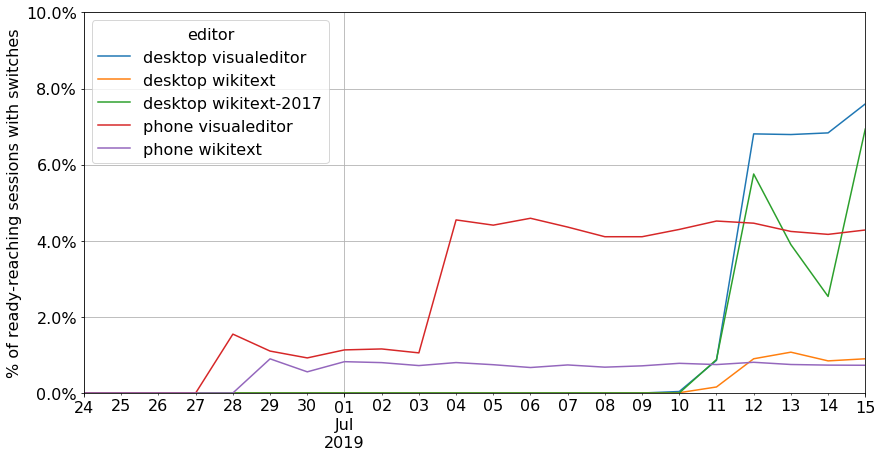

In [318]:
ax = (
    switches
    .plot(ylim=(0, 0.1))
)

ax.yaxis.set_major_formatter(pct_fmt)
plt.ylabel("% of ready-reaching sessions with switches")
plt.xlabel(None);

# Impact of loading screen improvements

While I'm looking at ready rates and ready times, let me check the impact of [the mobile visual editor's improved loading screen](https://phabricator.wikimedia.org/T210626), which was deployed as part of [Mediawiki 1.33-wmf.21](https://www.mediawiki.org/wiki/MediaWiki_1.33/wmf.21#MobileFrontend) (Tue, 12 Mar–Thu, 14 Mar 2019).

In [282]:
hist_ready_times["2019-03-04":"2019-03-22"].applymap(int)

,10th_percentile,median,90th_percentile
date,,,
2019-03-04,122,1384,5543
2019-03-05,139,1433,5010
2019-03-06,125,1308,4364
2019-03-07,136,1468,5384
2019-03-08,127,1444,5320
2019-03-09,140,1452,5410
2019-03-10,130,1422,5351
2019-03-11,126,1395,5226
2019-03-12,130,1387,5236


In [304]:
# Before-to-after change
before = hist_ready_times["2019-03-04": "2019-03-11"].mean()
after = hist_ready_times["2019-03-15": "2019-03-22"].mean()
timing_change = (
    ((after / before ) - 1)
    .apply(pct_str)
    .to_frame()
    .rename({0: "change after deploy"}, axis=1)
    .rename(lambda x: x.replace("_", " "))
)

In [305]:
timing_change

,change after deploy
10th percentile,37.7%
median,12.0%
90th percentile,11.3%


In [307]:
timing_change.reset_index().pipe(df_to_remarkup)

| index | change after deploy
| ----- | ----- 
| 10th percentile | 37.7%
| median | 12.0%
| 90th percentile | 11.3%



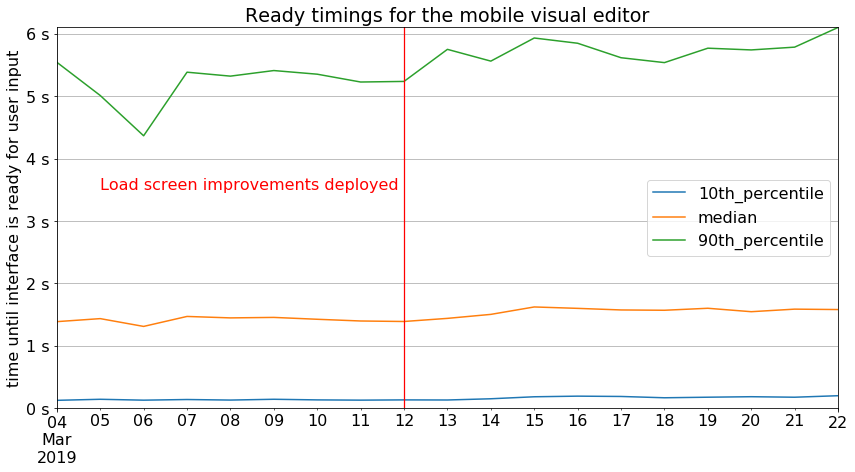

In [297]:
ax = hist_ready_times["2019-03-04": "2019-03-22"].plot(ylim=0)
ax.yaxis.set_major_formatter(FuncFormatter(
    lambda x, pos: str(int(x/1000)) + " s"
))   
plt.axvline("2019-03-12", color="red", linewidth=1.25)
plt.text("2019-03-05", 3500, "Load screen improvements deployed", size=16, color="red")
plt.ylabel("time until interface is ready for user input")
plt.xlabel(None)
plt.title("Ready timings for the mobile visual editor");

In [252]:
load_screen_ready_rates = global_ready_rate["visualeditor"]["2019-03-04": "2019-03-22"]

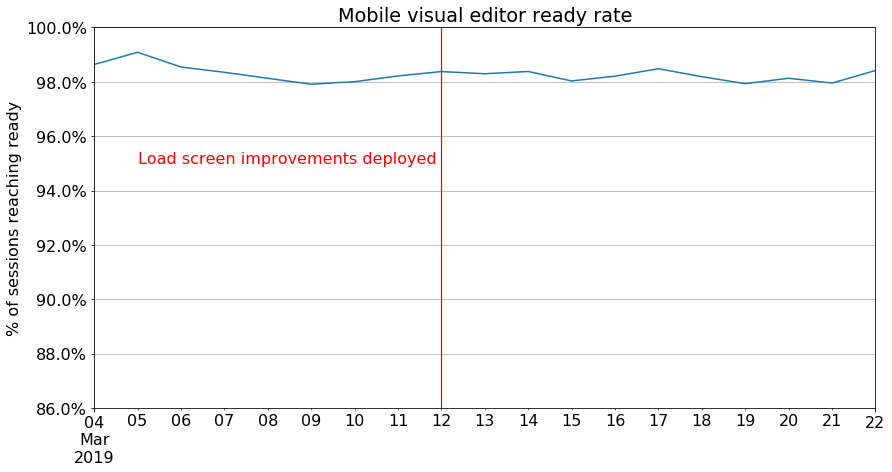

In [298]:
ax = load_screen_ready_rates.plot(ylim=(0.86, 1))
ax.yaxis.set_major_formatter(pct_fmt)
plt.axvline("2019-03-12", color="red", linewidth=1.25)
plt.text("2019-03-05", 0.95, "Load screen improvements deployed", size=16, color="red")
plt.xlabel(None)
plt.ylabel("% of sessions reaching ready")
plt.title("Mobile visual editor ready rate");